# Contact Prediction Examples

This example shows contact prediction with the ESM-1b and MSA Transformer models. Contact prediction is based on a logistic regression over the model's attention maps, without any finetuning of the language model. This methodology is based on our ICLR 2021 paper, "Transformer protein language models are unsupervised structure learners." (https://openreview.net/pdf?id=fylclEqgvgd). A pair of amino acids is defined to be in contact when Cb-Cb distance is within 8 angstroms. 

In [1]:
!pip -q install fair-esm Bio
import matplotlib.pyplot as plt
import esm
import torch
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string

     |████████████████████████████████| 271 kB 12.7 MB/s 
     |████████████████████████████████| 2.3 MB 65.4 MB/s 


In [2]:
torch.set_grad_enabled(False)

## Data Loading

This sets up some sequence loading utilities for ESM-1b (`read_sequence`) and the MSA Transformer (`read_msa`).

In [3]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str, nseq: int) -> List[Tuple[str, str]]:
    """ Reads the first nseq sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq)))
            for record in itertools.islice(SeqIO.parse(filename, "fasta"), nseq)]

In [4]:
!git clone https://github.com/JinyuanSun/small_datas.git

Cloning into 'small_datas'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


## Run ESM-1b Contact Prediction

In [5]:
esm1b, esm1b_alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
esm1b = esm1b.eval().cuda()
esm1b_batch_converter = esm1b_alphabet.get_batch_converter()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S-contact-regression.pt


In [23]:
def embedder(datasets, batch_size, esm_model="esm1b_t33_650M_UR50S", repr_layers=33):
    esm_model, alphabet = torch.hub.load("facebookresearch/esm:main", esm_model)
    #esm1b, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
    esm_model.cuda()
    batch_converter = alphabet.get_batch_converter()
    sequence_representations = {}
    i = 0
    while i in range(len(datasets)):
        if i + batch_size < len(datasets):
            subset = datasets[i: i +batch_size]
        else:
            subset = datasets[i: ]

        batch_labels, batch_strs, batch_tokens = batch_converter(subset)
        # Extract per-residue representations (on CPU)
        with torch.no_grad():
            results = esm_model(batch_tokens.cuda(), repr_layers=[repr_layers], return_contacts=False)
        token_representations = results["representations"][repr_layers].to(device="cpu")

        # Generate per-sequence representations via averaging
        # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
        i += batch_size
        for j, (_, seq) in enumerate(subset):
            sequence_representations[seq] = token_representations[j, 1 : len(seq) + 1].mean(0)
    return sequence_representations



In [9]:
import pandas as pd
import numpy as np
!pip -q install seaborn
import seaborn as sns

In [14]:
train_data = pd.read_csv('small_datas/S3839_training.csv', sep=',')
test_data = pd.read_csv('small_datas/S259_test.csv', sep=',')

In [15]:
train_data.head()

,index,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq
0,9,1A5E,L,121,R,0.66,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...
1,10,1A5E,L,37,S,0.71,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGASPNAPNSYGR...
2,11,1A5E,W,15,D,0.17,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADDLATAAARGRVEEVRALLEAGALPNAPNSYGR...
3,12,1A5E,D,74,N,-2.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...
4,13,1A5E,P,81,L,0.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...


In [ ]:
training_data_seqs = list(set(train_data['sequence'].tolist() + train_data['mutant_seq'].tolist()))
training_embeddings = embedder(training_data_seqs, 5)

Using cache found in /root/.cache/torch/hub/facebookresearch_esm_main


In [ ]:
esm1b_batch_labels, esm1b_batch_strs, esm1b_batch_tokens = esm1b_batch_converter(esm1b_data)
esm1b_batch_tokens = esm1b_batch_tokens.cuda()
print(esm1b_batch_tokens.size(), esm1b_batch_tokens.dtype)  # Should be a 2D tensor with dtype torch.int64.

torch.Size([3, 315]) torch.int64


In [ ]:
# %%time
esm1b_contacts = esm1b.predict_contacts(esm1b_batch_tokens).cpu()

CPU times: user 377 ms, sys: 117 ms, total: 494 ms
Wall time: 508 ms


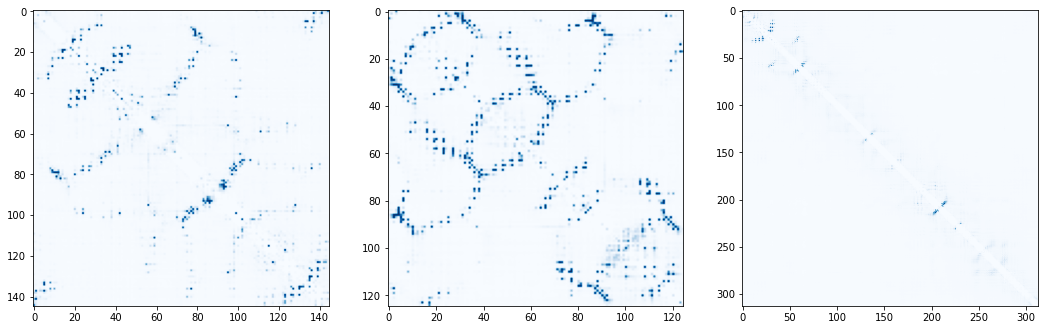

In [ ]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, contact, sequence in zip(axes, esm1b_contacts, esm1b_batch_strs):
    seqlen = len(sequence)
    ax.imshow(contact[:seqlen, :seqlen], cmap="Blues")
plt.show()

## Run MSA Transformer Contact Prediction

The MSAs used here are samples from the [`trRosetta` (v1) dataset](https://yanglab.nankai.edu.cn/trRosetta/benchmark/), also used in the MSA Transformer paper.

In [4]:
msa_transformer, msa_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_batch_converter = msa_alphabet.get_batch_converter()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm_msa1b_t12_100M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm_msa1b_t12_100M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm_msa1b_t12_100M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm_msa1b_t12_100M_UR50S-contact-regression.pt


In [6]:
data = [
    ("protein3",  "K A <mask> I S Q")
]
batch_labels, batch_strs, batch_tokens = msa_batch_converter(data)

In [8]:
batch_strs, batch_tokens

([['K A <mask> I S Q']],
 tensor([[[ 0, 15,  3,  5,  3,  3,  3,  3,  3,  3,  3,  3, 12,  3,  8,  3, 16]]]))

In [ ]:
msa_transformer.

In [6]:
msa_data = [
    read_msa("1PGA.fasta.a3m", 128)
]
msa_batch_labels, msa_batch_strs, msa_batch_tokens = msa_batch_converter(msa_data)
msa_batch_tokens = msa_batch_tokens.cuda()
print(msa_batch_tokens.size(), msa_batch_tokens.dtype)  # Should be a 3D tensor with dtype torch.int64.

torch.Size([1, 35, 57]) torch.int64


In [28]:
msa_batch_converter([('1PGA', 'M L')])

([['1PGA']], [['M L']], tensor([[[ 0, 20,  3,  4]]]))

In [13]:
# %%time
msa_contacts = msa_transformer.predict_contacts(msa_batch_tokens).cpu()

In [30]:
embeds = msa_transformer(msa_batch_tokens, repr_layers=[12])
embeds['representations'][12].shape

torch.Size([2, 115, 141, 768])

In [47]:
wt = embeds['representations'][12][0][0].mean(0).cpu()
mt = embeds['representations'][12][1][0].mean(0).cpu()

In [48]:
# wt, mt

In [49]:
import numpy as np
np.linalg.norm(wt-mt)

0.5835294

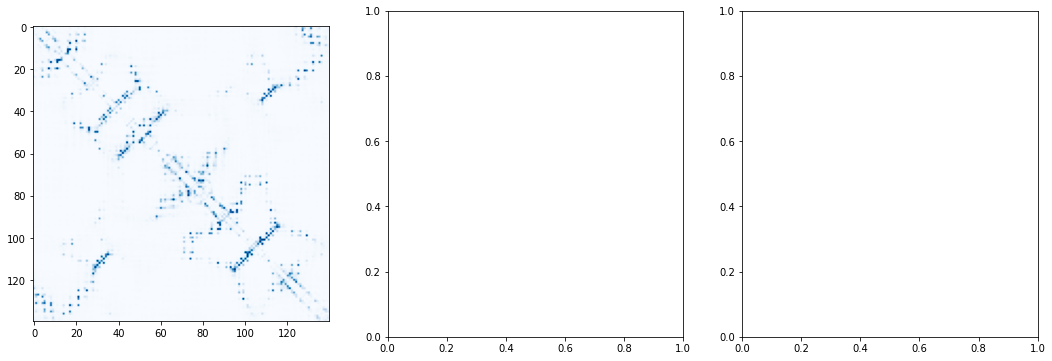

In [15]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, contact, msa in zip(axes, msa_contacts, msa_batch_strs):
    seqlen = len(msa[0])
    ax.imshow(contact[:seqlen, :seqlen], cmap="Blues")
plt.show()